# Preprocess on Sample Dataset
## Description of Dataset
We download the dataset from [kaggle datasci bowl 2017](www.kaggle.com)   
Here is the code to try preprocess the dicom data. The experiment is did on the sample dataset. 
Reference:  
- [shartoo's blog about medical image process(In Chinese)](http://shartoo.github.io/medical_image_process/)
- [gzuidhof's preprocessing tutorial](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial)


In [4]:
% matplotlib inline 
import numpy as np 
import pandas as pd 
import dicom
import os 
import scipy.ndimage
import matplotlib.pyplot as plt 
from skimage import measure, morphology 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection 

INPUT_FOLDER = '..\\sample_images\\'
patients = os.listdir(INPUT_FOLDER) 
patients.sort()


c:\python352\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)




#### How to load a scan?
A scan contains information of 3D-space. Thus they are organized as combination of multiple slices.
`ImagePositionPatient` is the coordinate of the first verxel. We sort it by axis `z`(from top to bottom). Calculate the slice thickness for the further stacking the slices on axis `z`.

In [5]:
def load_scan(path):
    slices = [dicom.read_file(os.path.join(path, f)) for f in os.listdir(path)]
    slices.sort(key=lambda x:float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2]-slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    
    for s in slices:
        s.SliceThickness = slice_thickness 
    
    return slices 




#### Hounsfiled Unit(HU)
As many parts of tissues will be scaned, direct observation without thresholding on the radiodensity approximately provides nothing useful. 

In [6]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image==-2000] = 0
    
    for ind, slc in enumerate(slices):
        intercept = slc.RescaleIntercept 
        slope = slc.RescaleSlope 
        if slope!=1:
            image[ind] = slope*image[ind].astype(np.float64)
            image[ind] = image[ind].astype(np.int16)
        image[ind] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)
        

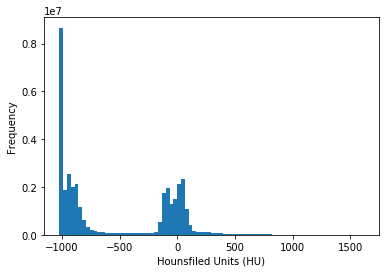

In [7]:
eg_patient = load_scan(INPUT_FOLDER + patients[0])
eg_patient_pixels = get_pixels_hu(eg_patient)
plt.hist(eg_patient_pixels.flatten(), bins=80)
plt.xlabel('Hounsfiled Units (HU)')
plt.ylabel('Frequency')

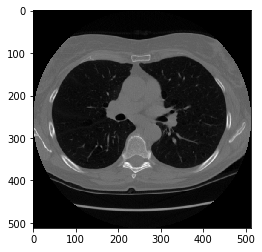

In [8]:
plt.imshow(eg_patient_pixels[80], cmap=plt.cm.gray)

In [9]:
def resample(image, scan, new_spacing=[1,1,1]):
    """
        This function is used for rescale all the slices of a patient 
        to the same resolution.
    """
    cur_spacing = np.array([scan[0].SliceThickness]+scan[0].PixelSpacing, dtype=np.float32)
    
    resize_factor = cur_spacing / new_spacing
    new_real_shape = image.shape * resize_factor 
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape 
    new_spacing = cur_spacing / real_resize_factor 
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing
    


In [10]:
eg_resampled, spacing = resample(eg_patient_pixels, eg_patient, [1,1,1])
print("Shape before resampling\t", eg_patient_pixels.shape)
print("Shape after resampling\t", eg_resampled.shape)



Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)


In [11]:
def plot_3d(image, threshold=-300):
    p = image.transpose(2, 1, 0)
    verts, faces, _, _ = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    mesh.set_facecolor([0.5, 0.5, 1])
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    

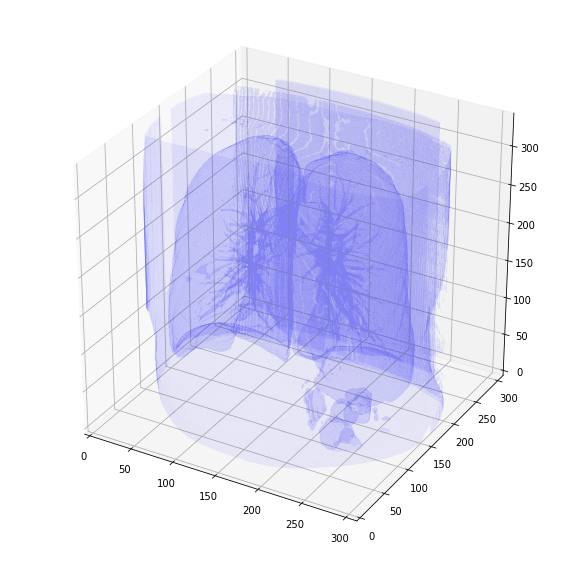

In [24]:
plot_3d(eg_resampled)

In [14]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0]/20)+1, 4, figsize=(50, 50))
    for i in range(0, scan.shape[0], 5):
        plots[int(i/20), int((i%20)/5)].axis('off')
        plots[int(i/20), int((i%20)/5)].imshow(scan[i], cmap=plt.cm.bone)

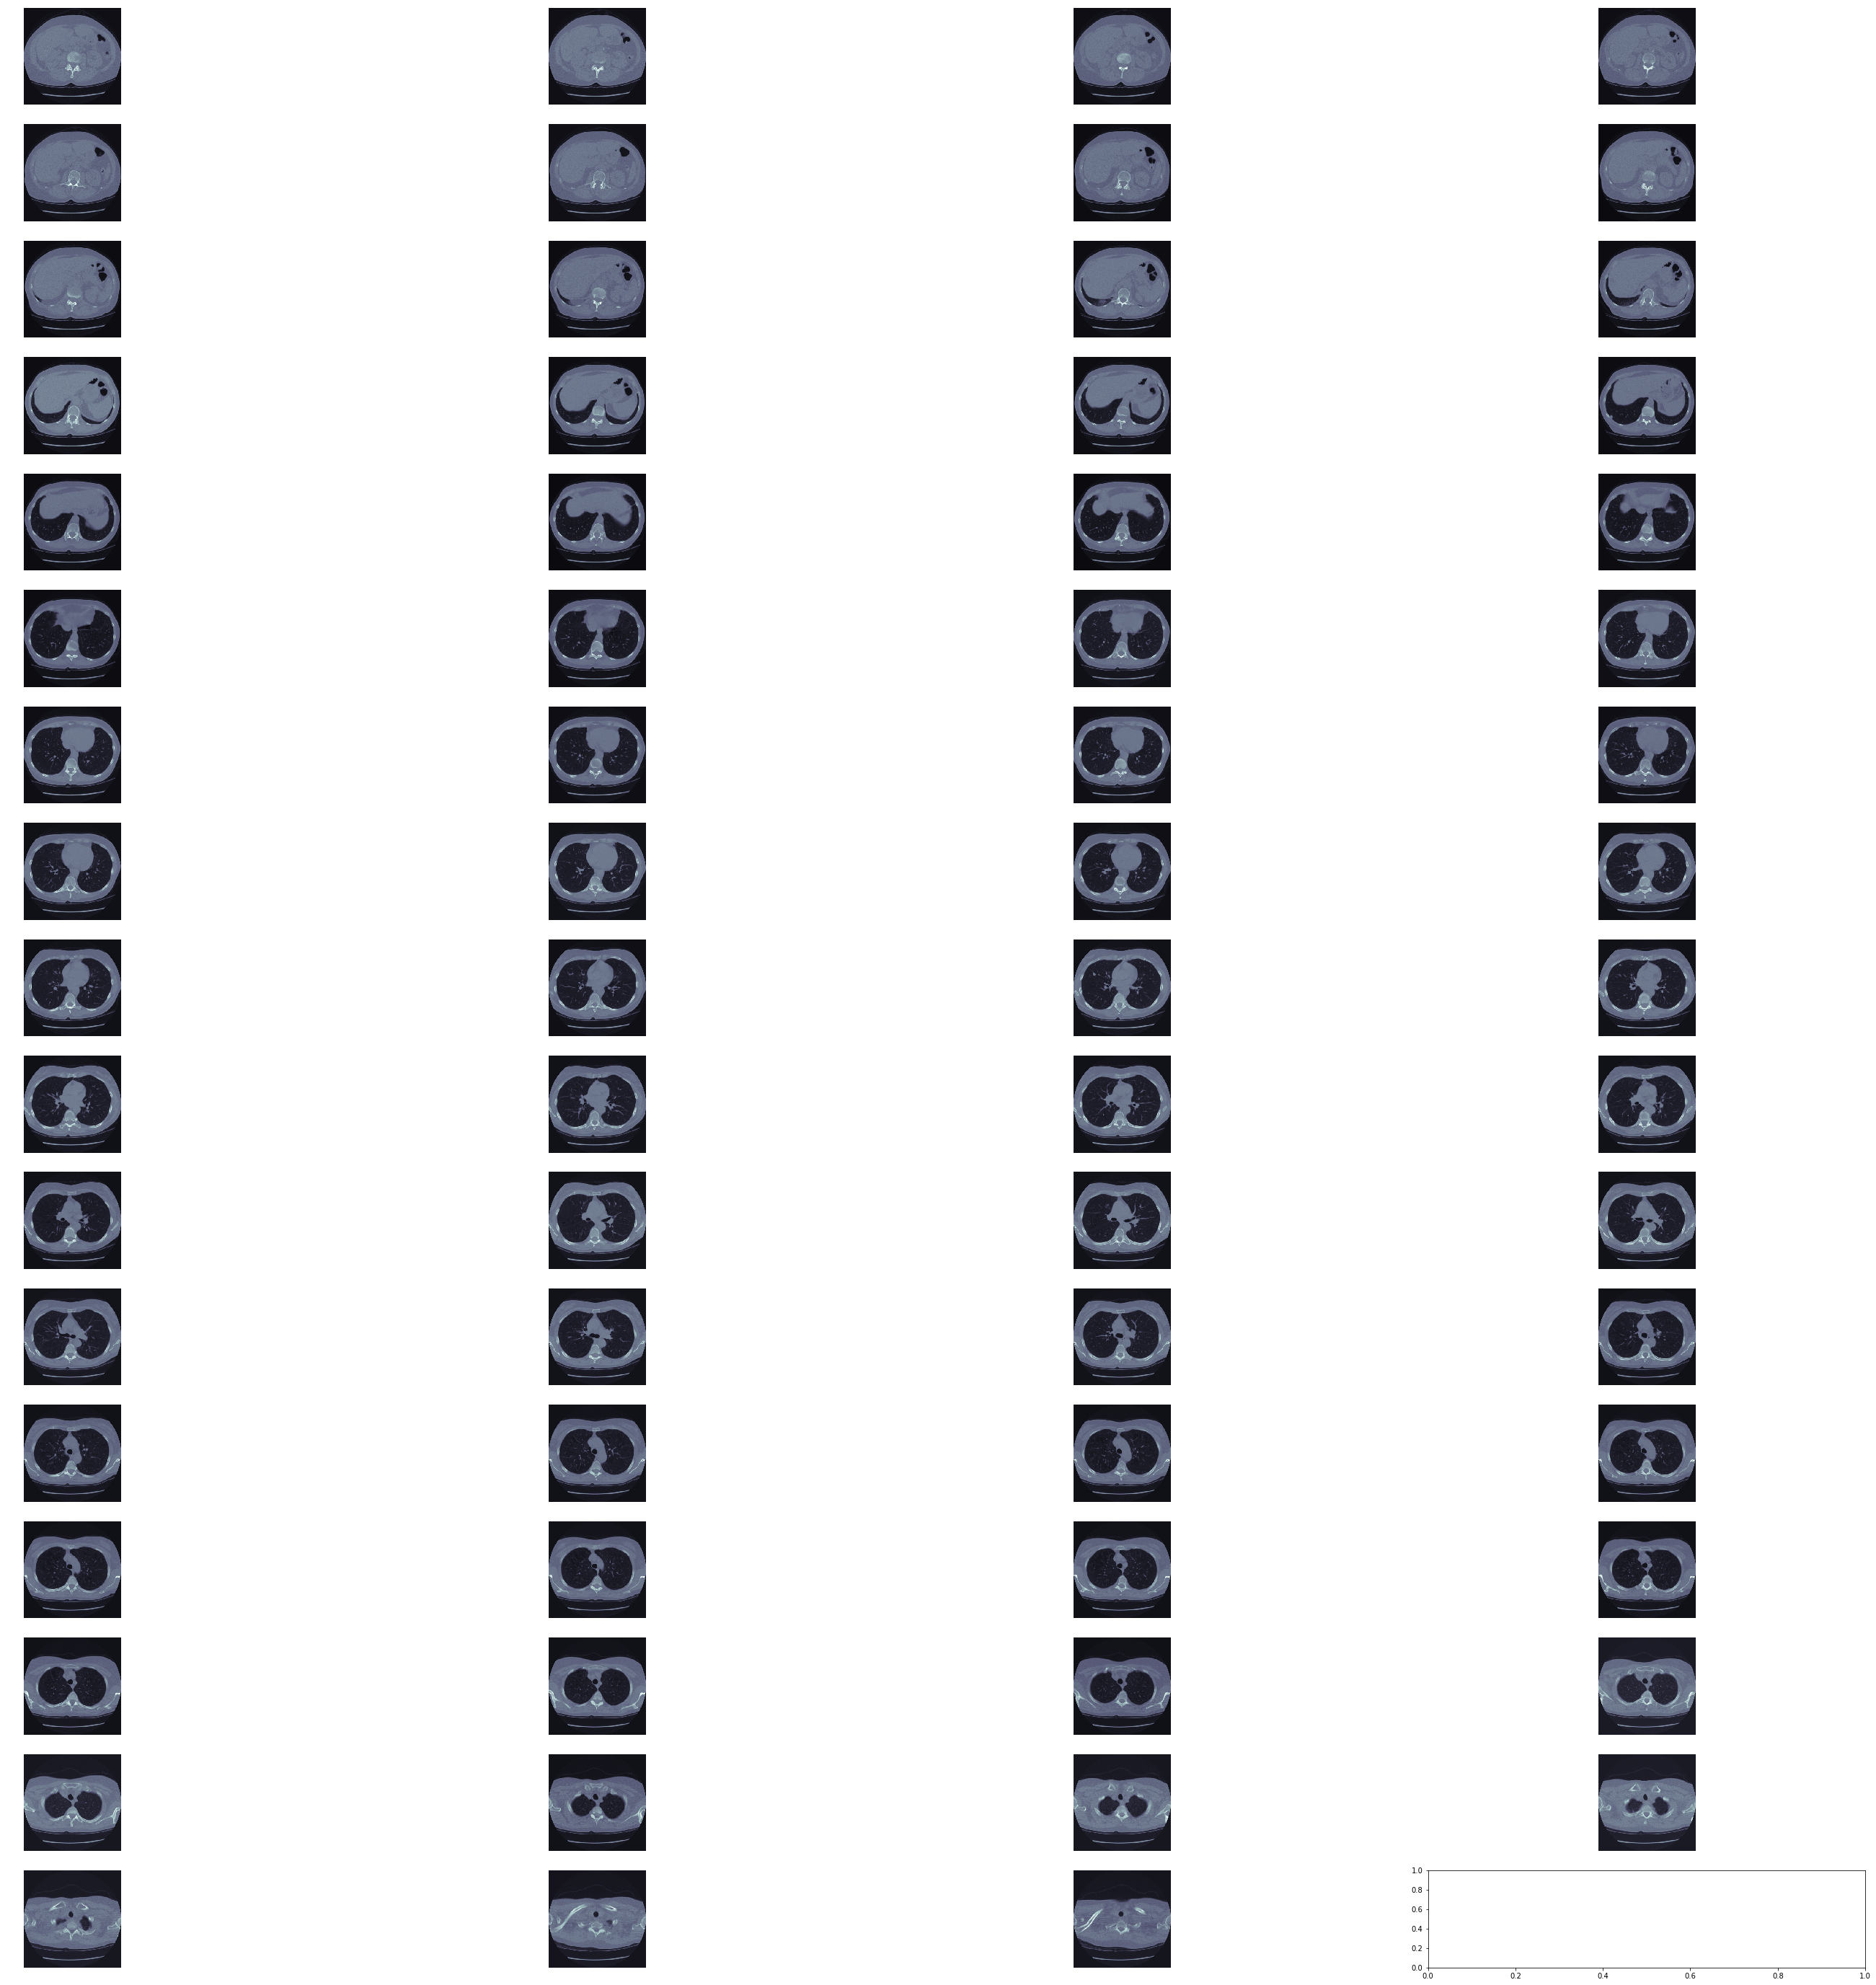

In [15]:
plot_ct_scan(eg_resampled)

## Lung Segmentation


In [20]:
def segment_lung(img, fill_lung_structures=True):
    
    def largest_label_volume(im, bg=-1):
        vals, counts = np.unique(im, return_counts=True)
        counts = counts[vals != bg]
        vals = vals[vals != bg]
        if len(counts) > 0:
            return vals[np.argmax(counts)]
        else:
            return None
        
    
    # 阈值化得到二值化图片 1或2
    binary_img = np.array(img > -320, dtype=np.int8)+1
    # 标出8连通区域，联通为1 
    labels = measure.label(binary_img)
    # 从第0层的(0,0)处像素得出背景的颜色
    background_label = labels[0][0][0] 
    # 把背景标为2
    binary_img[background_label == labels] = 2 
    
    if fill_lung_structures:
        for i, axial_slice in enumerate(binary_img):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            # 得到占用像素最多的标记
            l_max = largest_label_volume(labeling, bg=0)
    
            if l_max is not None:
                binary_img[i][labeling!=l_max] = 1
    
    binary_img -= 1
    binary_img = 1-binary_img 
    
    labels = measure.label(binary_img, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None:
        binary_img[labels != l_max] = 0 
    
    return binary_img
                

In [21]:
seged_lung = segment_lung(eg_resampled, False)
seged_lung_fill = segment_lung(eg_resampled, True)

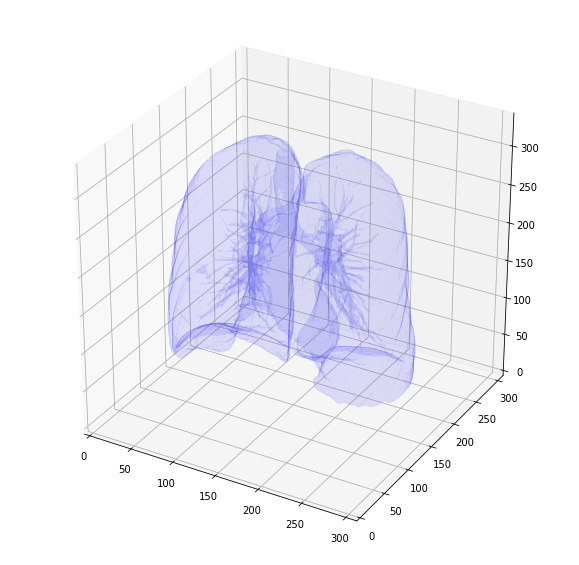

In [22]:
plot_3d(seged_lung, 0)

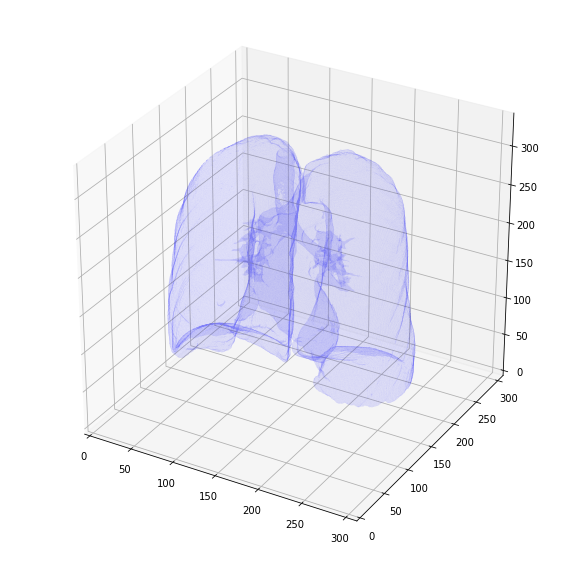

In [23]:
plot_3d(seged_lung_fill, 0)